# Outline of project

* Dataset being imported
* Visualize some aspect of the dataset
* Create Train and Validation dataset
* Create Our Vocabulary and tokenizer
* Create the Model
* setup the training loop for the model
* Visualizatoin of model prediction

Metrics Blue, Earlystoping as per paper,  


## Imports

In [2]:
import numpy as np
import os, random
import pandas as pd
import spacy
import torch
from torch import nn
from torch.nn.utils.rnn import pad_sequence, unpad_sequence
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from torchvision.transforms import transforms
from torchvision.models import vgg19
from tqdm import tqdm
from torchsummary import torchsummary
import torch.nn.functional as F
import seaborn as sns
from collections import defaultdict
import matplotlib.pyplot as plt
from PIL import Image
from collections import defaultdict
from nltk.translate.bleu_score import corpus_bleu

## Data Visualization

As per dataset decription, each image has 5 captions avaialable let's see a few of them and how they look like

In [3]:
def load_dataset_dict(caption_path):
    df = pd.read_csv(caption_path)
    caption_dict = defaultdict(list)
    for _, row in df.iterrows():
        caption_dict[row.image].append(row.caption)
    return caption_dict

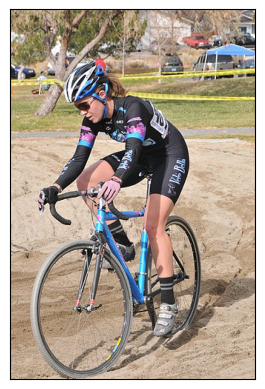

A woman in a race turning a corner .
A woman is riding a blue bicycle in a park .
Cyclist speeding down the trail .
Female cyclist riding on a dirt course .
Woman on blue bicycle wearing helmet


In [4]:
image_id, captions = random.choice(list(load_dataset_dict("data/captions.txt").items()))
data_dir = "data/images"
full_image_path = os.path.join(data_dir, image_id)
image = Image.open(full_image_path)
plt.xticks([])
plt.yticks([])
plt.imshow(image)
plt.show()
for caption in captions:
    print(caption)


## EDA

In [4]:
df = pd.read_csv("data/captions.txt")
df_captions = df.caption

In [5]:
def count_words(df):
    vocabulary = []
    for txt in df.caption.values:
        vocabulary.extend(txt.split())
    counter = defaultdict(int)

    for word in vocabulary:
        counter[word.lower()] += 1
    sorted_items = sorted(counter.items(), key=lambda item: item[-1], reverse=True)


    df = pd.DataFrame(sorted_items, columns=['word', 'count'])

    return df

df_counter = count_words(df)

In [6]:
df_counter.head(10)

,word,count
0,a,62986
1,.,36577
2,in,18974
3,the,18418
4,on,10743
5,is,9345
6,and,8851
7,dog,8136
8,with,7765
9,man,7265


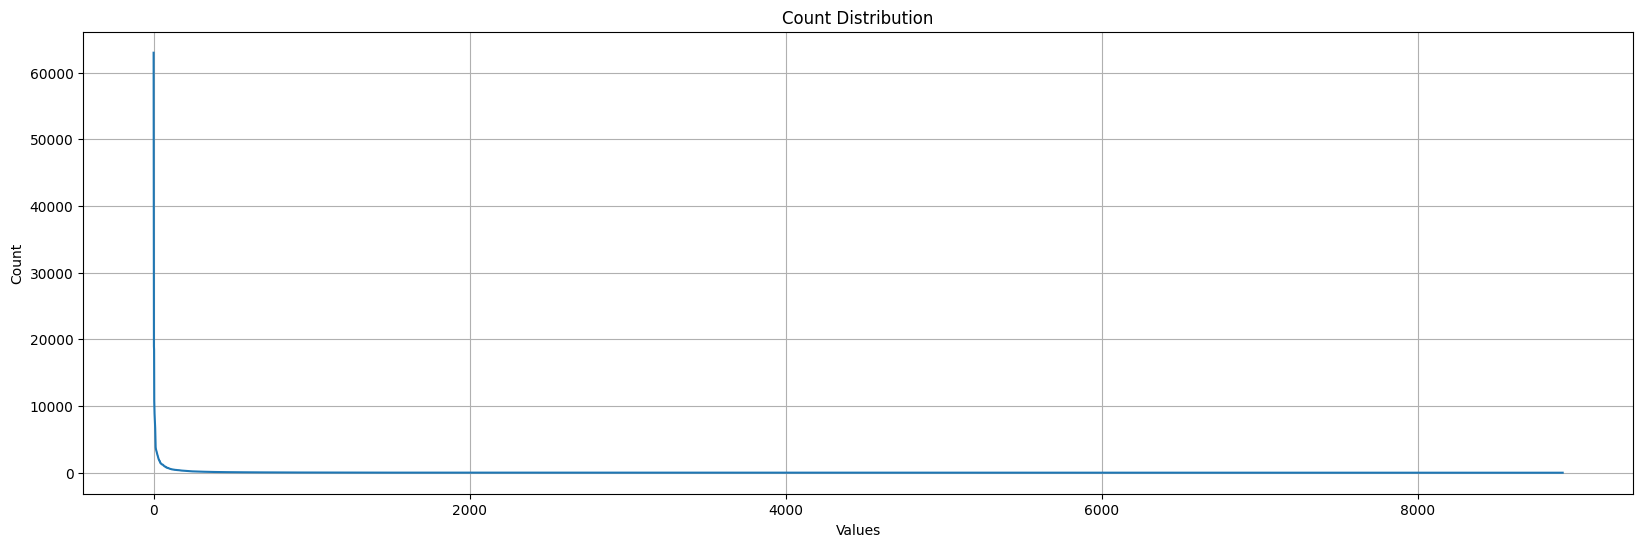

In [7]:
df_counter["count"].plot(grid=True, figsize=(20, 6))
plt.title("Count Distribution")
plt.xlabel("Values")
plt.ylabel("Count")
plt.show()

Text(0.5, 1.0, 'plot of count vs words')

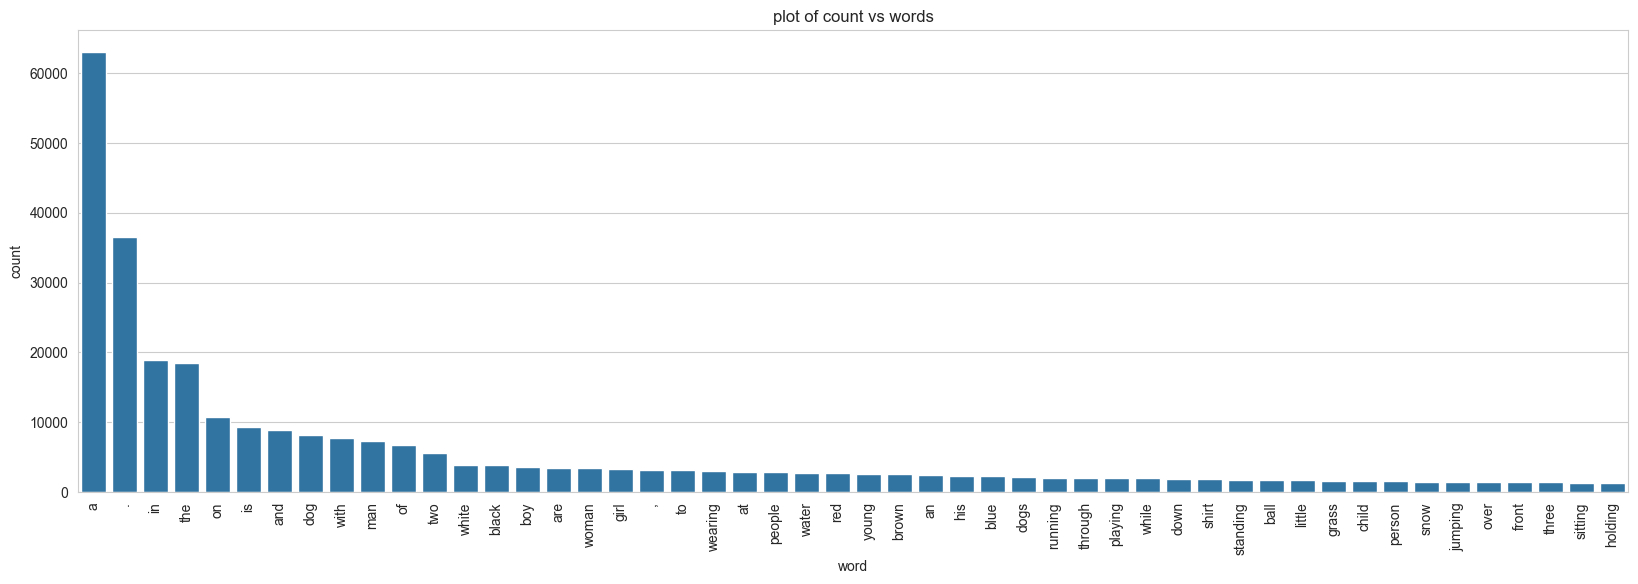

In [8]:
sns.set_style(style="whitegrid")
plt.figure(figsize=(20, 6))
sns.barplot(data=df_counter[:50], y='count', x="word")
plt.xticks(rotation="vertical")
plt.title("plot of count vs words")

In [9]:
"My name is Nathan".split()

['My', 'name', 'is', 'Nathan']

In [14]:
nlp = spacy.load("en_core_web_sm")
df['cal_len'] = df['caption'].apply(lambda x: len(nlp.tokenizer(x)))


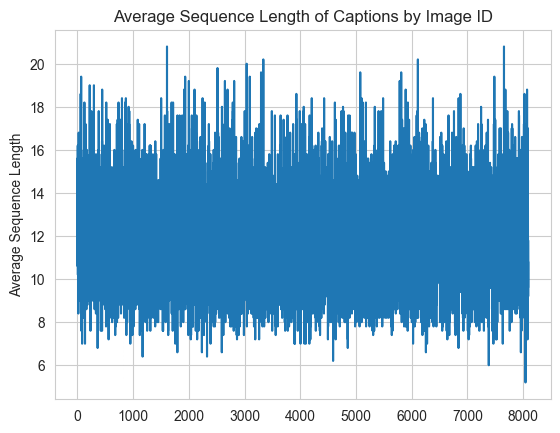

In [ ]:
nlp = spacy.load("en_core_web_sm")
df['sequence_length'] = df['caption'].apply(lambda x: len(nlp.tokenizer(x)))

# Step 3: Group by 'image_id' and calculate the average sequence length
avg_sequence_length = df.groupby('image')['sequence_length'].mean().reset_index()
avg_sequence_length['sequence_length'].plot()
plt.ylabel('Average Sequence Length')
plt.title('Average Sequence Length of Captions by Image ID')
plt.show()

## Train, Val Split

In [5]:
def train_val_split(caption_data, train_size=0.8, shuffle=True):
    """Split the captioning dataset into train and validation sets.

    Args:
        caption_data (dict): Dictionary containing the mapped caption data
        train_size (float): Fraction of all the full dataset to use as training data
        shuffle (bool): Whether to shuffle the dataset before splitting

    Returns:
        Traning and validation datasets as two separated dicts
    """

    # 1. Get the list of all image names
    all_images = list(caption_data.keys())

    # 2. Shuffle if necessary
    if shuffle:
        np.random.shuffle(all_images)

    # 3. Split into training and validation sets
    train_size = int(len(caption_data) * train_size)

    training_data = {
        img_name: caption_data[img_name] for img_name in all_images[:train_size]
    }
    validation_data = {
        img_name: caption_data[img_name] for img_name in all_images[train_size:]
    }

    # 4. Return the splits
    return training_data, validation_data

In [6]:
df = pd.read_csv("data/captions.txt")
data_dict = {}
caption_dict = defaultdict(list)
for _, row in df.iterrows():
    caption_dict[row.image].append(row.caption)
train_data, val_data = train_val_split(caption_dict)

In [7]:
for i in train_data.values():
    for j in i:
        print(j)
    break

A kayaker fights the rapids .
a man in a green kayak paddles down some rapids in front of a waterfall
A man kayaking down rapids .
A man kayaking through rapids in a river
A person in a green canoe paddles down rapids carrying oars and wearing an orange and black top .


In [8]:
hash_map = set()
for caption_list in train_data.values():
    for caption in caption_list:
        for word in caption.split():
            hash_map.add(word.lower())
len(hash_map)


8035

In [9]:
hash_map_val = set()
for caption_list in val_data.values():
    for caption in caption_list:
        for word in caption.split():
            hash_map_val.add(word.lower())
len(hash_map_val)

4220

## Vocabulary and tokenizer

In [10]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 23.5 MB/s eta 0:00:00 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [11]:

class Vocabulary():
    spacy_eng = spacy.load("en_core_web_sm")

    
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {v:k for k,v in self.itos.items()}
        self.freq_threshold = freq_threshold

    
    def __len__(self):
        return len(self.itos)


    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in Vocabulary.spacy_eng.tokenizer(text)]
    
    def build_vocabulary(self, sentence_list):
        frequency = {}
        idx = 4

        for sentence in sentence_list:
            for token in self.tokenizer_eng(sentence):

                frequency[token] = 1 + frequency.get(token, 0)

                if frequency[token] == self.freq_threshold:
                    self.stoi[token] = idx
                    self.itos[idx] = token
                    idx += 1
    
    def tokenize(self, text):
        token_sent = self.tokenizer_eng(text)

        return [self.stoi[token] if token in self.stoi else self.stoi['<UNK>']
                for token in token_sent
            ]
    
    def vocabulary_size(self):
        return len(self.stoi)

In [12]:
vocabulary = Vocabulary(1)
vocabulary.build_vocabulary(pd.read_csv("data/captions.txt").caption.to_list())
vocabulary.vocabulary_size()

8508

In [13]:
vocabulary.tokenize("creates a human whose, name is not Tom James")

[5587, 4, 2634, 3150, 139, 7346, 9, 2183, 3, 3]

In [14]:
[vocabulary.itos[idx] for idx in [5587, 4, 2634, 3150, 139, 7346, 9, 2183, 3, 3]]

['creates', 'a', 'human', 'whose', ',', 'name', 'is', 'not', '<UNK>', '<UNK>']

In [15]:
vocabulary.stoi["<PAD>"]

0

In [16]:
class FlickrDataset(Dataset):
    max_len = 45
    def __init__(self, root_dir, data_dict, vocabulary: Vocabulary, transform=None, train=True):
        self.root_dir = root_dir
        self.data_dict = data_dict
        self.transform = transform

        # get the image and caption
        self.train = train
        self.caption = []
        self.item = self.setup_item()

        # Create our own vocabulary
        self.vocabulary = vocabulary
        self.sos_token = torch.tensor([self.vocabulary.stoi['<SOS>']], dtype=torch.int64)
        self.eos_token = torch.tensor([self.vocabulary.stoi['<EOS>']], dtype=torch.int64)
        self.pad_token = torch.tensor([self.vocabulary.stoi['<PAD>']], dtype=torch.int64)
    
    def __len__(self):
        return len(self.item)
    
    def setup_item(self):
        item = []
        if self.train:
            for image_id, image_captions in self.data_dict.items():
                for caption in image_captions:
                    self.caption.append(caption)
                    item.append((image_id, caption))
        else:
            for image_id, image_captions in self.data_dict.items():
                self.caption.extend(image_captions)
                item.append((image_id, image_captions))
        return item


    def __getitem__(self, index):
        # get image
        image_path = os.path.join(self.root_dir, self.item[index][0])
        img = Image.open(image_path).convert('RGB')

        if self.transform is not None:
            img = self.transform(img)
        
        # get caption
        caption = self.item[index][1]
        
        if self.train:
            cap_len = len(self.vocabulary.tokenize(caption))
            num_pad = FlickrDataset.max_len - cap_len - 2
            if num_pad < 0:
                raise ValueError("Caption too long")
            num_caption = torch.cat([
                        self.sos_token ,
                        torch.tensor(self.vocabulary.tokenize(caption), dtype=torch.int64),
                        self.eos_token,
                        torch.tensor([self.pad_token] * num_pad, dtype=torch.int64)], dim=0)
            return img, num_caption
        else:
            captions = torch.zeros(5, 45).to(torch.long)
            for idx, cap in enumerate(caption):
                cap_len = len(self.vocabulary.tokenize(cap))
                num_pad = FlickrDataset.max_len - cap_len - 2
                if num_pad < 0:
                    raise ValueError("Caption too long")
                num_caption =    torch.cat([
                        self.sos_token ,
                        torch.tensor(self.vocabulary.tokenize(cap), dtype=torch.int64),
                        self.eos_token,
                        torch.tensor([self.pad_token] * num_pad, dtype=torch.int64)], dim=0)

                captions[idx] = num_caption
            return img, torch.LongTensor(captions)


In [17]:
def get_loader(
        root_dir,
        data_dict,
        vocabulary,
        transform,
        train=True,
        batch_size=32,
        shuffle=True,
):
    dataset = FlickrDataset(root_dir=root_dir, data_dict=data_dict, vocabulary=vocabulary,
                        transform=transform, train=train)
        
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
    )
    return loader, dataset

### Testing Dataset(and DataLoader) for train and test with vocabulatry

In [18]:
vocabulary = Vocabulary(1)
vocabulary.build_vocabulary(pd.read_csv("data/captions.txt").caption.to_list())
vocabulary.vocabulary_size()

8508

In [19]:
folder = "data/images/"
df = pd.read_csv("data/captions.txt")
data_dict = {}
caption_dict = defaultdict(list)
for _, row in df.iterrows():
    caption_dict[row.image].append(row.caption)
train_data, val_data = train_val_split(caption_dict)

In [20]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                         std=[0.26862954, 0.26130258, 0.27577711])
])

In [21]:
train_dataset = FlickrDataset(root_dir=folder, data_dict=train_data,vocabulary=vocabulary,
                        transform=transform, train=True)

In [22]:
random_index = random.randint(0, len(train_dataset) - 1)

# Get the random element
random_image, random_label = train_dataset[random_index]

print("Random Shape:", random_image.shape)
print("Random Caption:", random_label.shape)

Random Shape: torch.Size([3, 224, 224])
Random Caption: torch.Size([45])


In [23]:
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
for image, caption in train_loader:
    print(caption.shape)
    print(image.shape)
    index = random.randint(0, 31)
    first_image = image[index]
    print(first_image.shape)
    first_caption = caption[index]
    print(first_caption.shape)
    break

torch.Size([32, 45])
torch.Size([32, 3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([45])


In [24]:
val_dataset = FlickrDataset(root_dir=folder, data_dict=val_data,vocabulary=vocabulary,
                        transform=transform, train=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6320349..2.145897].


Random Shape: torch.Size([3, 224, 224])
Random Caption: torch.Size([5, 45])


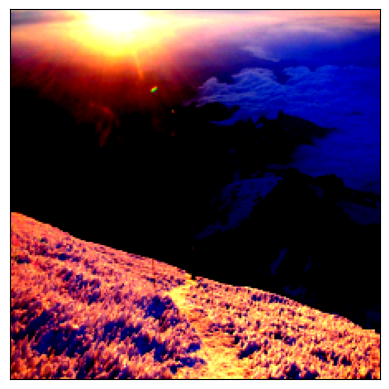

['<SOS>', 'a', 'man', 'among', 'steep', 'and', 'snowy', 'mountains', '.', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
['<SOS>', 'someone', 'hikes', 'down', 'a', 'steep', ',', 'frozen', 'mountainside', '.', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
['<SOS>', 'the', 'grass', 'has', 'ice', 'on', 'it', 'and', 'there', 'is', 'a', 'mountain', 'in', 'the', 'background', '.', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PA

In [25]:
random_index = random.randint(0, len(val_dataset) - 1)

# Get the random element
random_image, random_label = val_dataset[random_index]

print("Random Shape:", random_image.shape)
print("Random Caption:", random_label.shape)
plt.xticks([])
plt.yticks([])
plt.imshow(random_image.permute(1, 2,0))
plt.show()
print([vocabulary.itos[token] for token in random_label[0].tolist()])
print([vocabulary.itos[token] for token in random_label[1].tolist()])
print([vocabulary.itos[token] for token in random_label[2].tolist()])
print([vocabulary.itos[token] for token in random_label[3].tolist()])
print([vocabulary.itos[token] for token in random_label[4].tolist()])

In [26]:
folder

'data/images/'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7922626..1.9894764].


torch.Size([32, 5, 45])
torch.Size([32, 3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([5, 45])


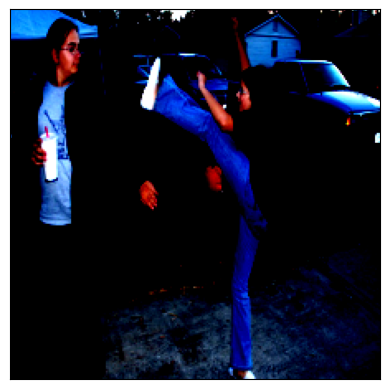

['<SOS>', 'a', 'girl', 'doing', 'a', 'kick', 'near', 'a', 'woman', '.', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
['<SOS>', 'a', 'girl', 'in', 'black', 'high', 'kicks', 'over', 'a', 'jack', '-', 'o', '-', 'lantern', '.', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
['<SOS>', 'a', 'girl', 'in', 'jeans', 'tries', 'to', 'show', 'an', 'adult', 'how', 'high', 'she', 'can', 'kick', '.', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '

In [27]:
val_loader, _ = get_loader(root_dir=folder, data_dict=val_data, vocabulary=vocabulary, transform=transform, train=False)

for image, caption in val_loader:
    print(caption.shape)
    print(image.shape)
    index = random.randint(0, 31)
    random_image = image[index]
    print(random_image.shape)
    random_label = caption[index]
    print(random_label.shape)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(random_image.permute(1, 2,0))
    plt.show()
    print([vocabulary.itos[token] for token in random_label[0].tolist()])
    print([vocabulary.itos[token] for token in random_label[1].tolist()])
    print([vocabulary.itos[token] for token in random_label[2].tolist()])
    print([vocabulary.itos[token] for token in random_label[3].tolist()])
    print([vocabulary.itos[token] for token in random_label[4].tolist()])
    break

## Model

In [31]:
from torchvision.models import vgg19, VGG19_Weights
import torch.nn as nn

### ecoder test

In [38]:
model = vgg19(weights=VGG19_Weights.DEFAULT)

In [47]:
model = nn.Sequential(*list(model.features.children())[:-1])

In [52]:
img, caption = train_dataset[0]
img.shape

torch.Size([3, 224, 224])

In [53]:
output = model(img)
output.shape

torch.Size([512, 14, 14])

### Encoder

In [227]:
class Encoder(nn.Module):

    def __init__(self, train_CNN=False):
        super(Encoder, self).__init__() # staying consistent with the paper by using vgg
        self.train_CNN = train_CNN
        self.model = vgg19()
        self.model = nn.Sequential(*list(self.model.features.children())[:-1])
        self.dim = 512
        #self.freeze()
        
    
    def freeze(self):
        for param in self.model.parameters():
            param.requires_grad = self.train_CNN

    def forward(self, images):
        features = self.model(images)
        features = features.permute(0, 2, 3, 1)
        features = features.view(features.shape[0], -1, features.shape[-1])
        return features # output should be of shape (batch_size, 196, 512)
    

In [228]:
import torchvision
from torchvision.models import ResNet101_Weights
class Encoder(nn.Module):
    """
    Encoder.
    """

    def __init__(self, encoded_image_size=14):
        super(Encoder, self).__init__()
        self.enc_image_size = encoded_image_size

        resnet = torchvision.models.resnet101()  # pretrained ImageNet ResNet-101

        # Remove linear and pool layers (since we're not doing classification)
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)

        # Resize image to fixed size to allow input images of variable size
        self.adaptive_pool = nn.AdaptiveAvgPool2d((encoded_image_size, encoded_image_size))
        self.dim = 2048
        #self.fine_tune()

    def forward(self, images):
        """
        Forward propagation.

        :param images: images, a tensor of dimensions (batch_size, 3, image_size, image_size)
        :return: encoded images
        """
        out = self.resnet(images)  # (batch_size, 2048, image_size/32, image_size/32)
        out = self.adaptive_pool(out)  # (batch_size, 2048, encoded_image_size, encoded_image_size)
        out = out.permute(0, 2, 3, 1)  # (batch_size, encoded_image_size, encoded_image_size, 2048)
        out = out.view(out.shape[0],-1,out.shape[-1])
        return out

### Test

In [205]:
image_path = 'data/images/10815824_2997e03d76.jpg'

# Load the image
image = Image.open(image_path)

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                         std=[0.26862954, 0.26130258, 0.27577711])
])

# Apply the transformation
ENCODER_DIM = 2048
DECODER_DIM = 256
EMBED_DIM = 64
ATTENTION_DIM = 128
image_tensor = transform(image)

# Add a batch dimension if needed
image_tensor = image_tensor.unsqueeze(0)
enocder = Encoder()
output = enocder(image_tensor)
print("encoded image shape: ", output.shape)


# caption
caption = "<SOS> A blonde horse and a blonde girl in a black sweatshirt are staring at a fire in a barrel .<EOS>"
caption = vocabulary.tokenize(caption)
caption = torch.tensor(caption).unsqueeze(0)
print("tokenize caption shape:", caption.shape)

# embedding the caption
embedding = nn.Embedding(vocabulary.vocabulary_size(), EMBED_DIM)
caption = embedding(caption)
print("embedded caption shape:", caption.shape)

# initlize your values for h and c
init_h = nn.Linear(ENCODER_DIM, DECODER_DIM)
init_c = nn.Linear(ENCODER_DIM, DECODER_DIM)

average_out = output.mean(dim=1)
h = init_h(average_out)
c = init_c(average_out)
print("shape of average encoder output:", average_out.shape)
print("shape of initial h:", h.shape)
print("shape of inital c:", c.shape)

## initilizeing predictions and alpha (will be returned)
prediction = torch.zeros(1, caption.shape[1], vocabulary.vocabulary_size())


## Attention
encoder_attention = nn.Linear(ENCODER_DIM, ATTENTION_DIM)
decorder_attention = nn.Linear(DECODER_DIM, ATTENTION_DIM)
attend = nn.Linear(ATTENTION_DIM, 1)

# Decoder
lstm = nn.LSTMCell(ENCODER_DIM+EMBED_DIM, DECODER_DIM)
fc = nn.Linear(DECODER_DIM, vocabulary.vocabulary_size())



for i in range(caption.shape[1]):
        
        ## attention forward method
        print("--------- START ATTENTION CALCULATION -----------")
        tmp_img = encoder_attention(output)
        tmp_h = decorder_attention(h).unsqueeze(1)
        print("encoder output attention shape:", {tmp_img.shape})
        print("hidden output attention shape:", {tmp_h.shape})
        add = nn.Tanh()(tmp_img + tmp_h)
        print("Sum of enocder and hidden output shape: ", {add.shape})
        att = attend(add).squeeze(2)
        print("non scaled attention score shape:", {att.shape})
        alpha = nn.Softmax(dim=1)(att).unsqueeze(1)
        print("alpha shape:", alpha.shape)
        weighted_context = torch.bmm(alpha, output).squeeze(1)
        print("full weighted context shape:", {weighted_context.shape})
        
        print("--------- DONE CALCULATING ATTENTION SCORE -----------")
        print(caption[:,i,:].shape)
        lstm_input = torch.cat([caption[:,i,:], weighted_context], dim=1)
        print("LSTM input shape:",lstm_input.shape)
        print("SUM of encoder and embed DIM", ENCODER_DIM+EMBED_DIM)
        h, c = lstm(lstm_input, (h, c))
        word_prop = fc(h)
        print("word_proabability shape:", word_prop.shape)
        prediction[:,i,:] = word_prop
        break

print("--------- DONE DECORDER -----------")
print("final predictions shape:", {prediction.shape}) 
print("Argmax", prediction.max(dim=-1))


Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /Users/ngkuissi/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth
100%|██████████| 171M/171M [00:11<00:00, 15.9MB/s] 


encoded image shape:  torch.Size([1, 196, 2048])
tokenize caption shape: torch.Size([1, 24])
embedded caption shape: torch.Size([1, 24, 64])
shape of average encoder output: torch.Size([1, 2048])
shape of initial h: torch.Size([1, 256])
shape of inital c: torch.Size([1, 256])
--------- START ATTENTION CALCULATION -----------
encoder output attention shape: {torch.Size([1, 196, 128])}
hidden output attention shape: {torch.Size([1, 1, 128])}
Sum of enocder and hidden output shape:  {torch.Size([1, 196, 128])}
non scaled attention score shape: {torch.Size([1, 196])}
alpha shape: torch.Size([1, 1, 196])
full weighted context shape: {torch.Size([1, 2048])}
--------- DONE CALCULATING ATTENTION SCORE -----------
torch.Size([1, 64])
LSTM input shape: torch.Size([1, 2112])
SUM of encoder and embed DIM 2112
word_proabability shape: torch.Size([1, 8508])
--------- DONE DECORDER -----------
final predictions shape: {torch.Size([1, 24, 8508])}
Argmax torch.return_types.max(
values=tensor([[0.2228, 

In [197]:
image_path = 'data/images/10815824_2997e03d76.jpg'

# Load the image
image = Image.open(image_path)

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                         std=[0.26862954, 0.26130258, 0.27577711])
])

# Apply the transformation
ENCODER_DIM = 512
DECODER_DIM = 256
EMBED_DIM = 64
ATTENTION_DIM = 128
image_tensor = transform(image)

# Add a batch dimension if needed
image_tensor = image_tensor.unsqueeze(0)
enocder = Encoder()
output = enocder(image_tensor)
print("encoded image shape: ", output.shape)


# caption
caption = "<SOS> A blonde horse and a blonde girl in a black sweatshirt are staring at a fire in a barrel .<EOS>"
caption = vocabulary.tokenize(caption)
caption = torch.tensor(caption).unsqueeze(0)
print("tokenize caption shape:", caption.shape)

# embedding the caption
embedding = nn.Embedding(vocabulary.vocabulary_size(), EMBED_DIM)
caption = embedding(caption)
print("embedded caption shape:", caption.shape)

# initlize your values for h and c
init_h = nn.Linear(ENCODER_DIM, DECODER_DIM)
init_c = nn.Linear(ENCODER_DIM, DECODER_DIM)

average_out = output.mean(dim=1)
h = init_h(average_out)
c = init_c(average_out)
print("shape of average encoder output:", average_out.shape)
print("shape of initial h:", h.shape)
print("shape of inital c:", c.shape)

## initilizeing predictions and alpha (will be returned)
prediction = torch.zeros(1, caption.shape[1], vocabulary.vocabulary_size())


## Attention
encoder_attention = nn.Linear(ENCODER_DIM, ATTENTION_DIM)
decorder_attention = nn.Linear(DECODER_DIM, ATTENTION_DIM)
attend = nn.Linear(ATTENTION_DIM, 1)

# Decoder
lstm = nn.LSTMCell(ENCODER_DIM+EMBED_DIM, DECODER_DIM)
fc = nn.Linear(DECODER_DIM, vocabulary.vocabulary_size())



for i in range(caption.shape[1]):
        
        ## attention forward method
        ## attention forward method
        tmp_img = encoder_attention(output)
        tmp_h = decorder_attention(h).unsqueeze(1)
        print("encoder output attention shape:", {tmp_img.shape})
        print("hidden output attention shape:", {tmp_h.shape})
        add = nn.Tanh()(tmp_img + tmp_h)
        print("Sum of enocder and hidden output shape: ", {add.shape})
        att = attend(add).squeeze(2)
        print("non scaled attention score shape:", {att.shape})
        alpha = nn.Softmax(dim=1)(att)
        print("alpha shape:", alpha.shape)
        weighted_context = (output * alpha.unsqueeze(2))
        print("unsqueze weight context shape:", weighted_context.shape)
        weighted_context = weighted_context.sum(dim=1)
        print("full weighted context shape:", {weighted_context.shape})
        
        print("--------- DONE CALCULATING ATTENTION SCORE -----------")
        print(caption[:,i,:].shape)
        lstm_input = torch.cat([caption[:,i,:], weighted_context], dim=1)
        print(lstm_input.shape)
        h, c = lstm(lstm_input, (h, c))
        word_prop = fc(h)
        print("word_proabability shape:", word_prop.shape)
        prediction[:,i,:] = word_prop
        break

print("--------- DONE DECORDER -----------")
print("final predictions shape:", {prediction.shape}) 
print("Argmax", prediction.argmax(dim=-1))



encoded image shape:  torch.Size([1, 196, 512])
tokenize caption shape: torch.Size([1, 24])
embedded caption shape: torch.Size([1, 24, 64])
shape of average encoder output: torch.Size([1, 512])
shape of initial h: torch.Size([1, 256])
shape of inital c: torch.Size([1, 256])
encoder output attention shape: {torch.Size([1, 196, 128])}
hidden output attention shape: {torch.Size([1, 1, 128])}
Sum of enocder and hidden output shape:  {torch.Size([1, 196, 128])}
non scaled attention score shape: {torch.Size([1, 196])}
alpha shape: torch.Size([1, 196])
unsqueze weight context shape: torch.Size([1, 196, 512])
full weighted context shape: {torch.Size([1, 512])}
--------- DONE CALCULATING ATTENTION SCORE -----------
torch.Size([1, 64])
torch.Size([1, 576])
word_proabability shape: torch.Size([1, 8508])
--------- DONE DECORDER -----------
final predictions shape: {torch.Size([1, 24, 8508])}
Argmax tensor([[919,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   

### Attention

In [248]:
device = "cpu"
class ImageEncoder(nn.Module):
    def __init__(self, enc_image_size=14):
        super(ImageEncoder, self).__init__()
        self.enc_image_size = enc_image_size

        # pretrained ImageNet ResNet-101
        resnet = torchvision.models.resnet101(pretrained=True)

        # remove linear and pool layers
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)

        # resize image to fixed size using adaptive pool to allow input images of variable size
        self.adaptive_pool = nn.AdaptiveAvgPool2d((enc_image_size, enc_image_size))

        self.fine_tune()

    def fine_tune(self, fine_tune=True):
        """
        Allow or prevent computation of the gradients for convolutional blocks 2 through 4 of the image encoder.
        :param fine_tune: boolean
        """
        for param in self.resnet.parameters():
            param.requires_grad = False
        # if fine-tuning, fine-tune convolutional blocks 2 through 4
        for child in list(self.resnet.children())[5:]:
            for param in child.parameters():
                param.requires_grad = fine_tune
    
    def forward(self, images):
        """
        Forward propagation.
        :param images: images, a tensor of dim (batch_size, 3, image_size, image_size)
        :return enc_images: encoded repr of images, a tensor of dim (batch_size, enc_image_size, enc_image_size, 2048)
        """
        out = self.resnet(images)       # (batch_size, 2048, image_size/32, image_size/32)
        out = self.adaptive_pool(out)   # (batch_size, 2048, enc_image_size, enc_image_size)
        out = out.permute(0, 2, 3, 1)   # (batch_size, enc_image_size, enc_image_size, 2048)
        return out
    
class BahdanauAttention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        """
        :param encoder_dim: feature size of encoded images
        :param decoder_dim: size of decoder's RNN
        :param attention_dim: size of the attention network
        """
        super(BahdanauAttention, self).__init__()
        self.encoder_attn = nn.Linear(encoder_dim, attention_dim)   # linear layer to transform encoder's output
        self.decoder_attn = nn.Linear(decoder_dim, attention_dim)   # linear layer to transform decoder's output
        self.full_attn = nn.Linear(attention_dim, 1)
    
    def forward(self, encoder_out, decoder_hidden):
        """
        Forward propagation (uses Multiplicative attention).
        :param encoder_out: encoded images, a tensor of dim (batch_size, num_pixels, encoder_dim)
        :param decoder_hidden: previous decoder output, a tensor of dim (batch_size, decoder_dim)
        """
        attn1 = self.encoder_attn(encoder_out)          # (batch_size, num_pixels, attention_dim)
        attn2 = self.decoder_attn(decoder_hidden)       # (batch_size, attention_dim)
        attn = self.full_attn(F.relu(attn1 + attn2.unsqueeze(1)))    # (batch_size, num_pixels, 1)

        # apply softmax to calculate weights for weighted encoding based on attention
        alpha = F.softmax(attn, dim=1)                  # (batch_size, num_pixels, 1)
        attn_weighted_encoding = (encoder_out * alpha).sum(dim=1)  # (batch_size, encoder_dim)
        alpha = alpha.squeeze(2)  # (batch_size, num_pixels)
        return attn_weighted_encoding, alpha
    
attention = BahdanauAttention(encoder_dim=256, decoder_dim=512, attention_dim=128)

encoder_outputs = torch.rand(32, 10, 256)  # Batch size 32, sequence length 10, encoder dim 256
decoder_hidden = torch.rand(32, 512)       # Batch size 32, decoder dim 512

context_vector, attn_weights = attention(encoder_outputs, decoder_hidden)
print(context_vector.shape)  # (32, 256)
print(attn_weights.shape)    # (32, 10)
print(context_vector.argmax(dim=-1))
print(attn_weights.max(dim=-1))

torch.Size([32, 256])
torch.Size([32, 10])
tensor([ 10,  47,  23,  28, 147, 220, 120, 108, 178,   2, 140,  50, 178, 178,
         58, 187, 245, 123,  36, 166, 194, 216, 136,  88,  56, 134,   3,  15,
        200,  41, 228, 117])
torch.return_types.max(
values=tensor([0.1051, 0.1163, 0.1101, 0.1133, 0.1043, 0.1125, 0.1125, 0.1099, 0.1076,
        0.1077, 0.1168, 0.1071, 0.1118, 0.1078, 0.1120, 0.1126, 0.1087, 0.1157,
        0.1097, 0.1082, 0.1076, 0.1055, 0.1167, 0.1185, 0.1127, 0.1215, 0.1079,
        0.1118, 0.1072, 0.1259, 0.1073, 0.1132], grad_fn=<MaxBackward0>),
indices=tensor([1, 1, 1, 9, 4, 4, 9, 5, 3, 3, 0, 9, 4, 9, 0, 4, 7, 4, 8, 2, 6, 9, 3, 6,
        0, 1, 1, 8, 9, 9, 5, 2]))


In [309]:
from torchvision import models
# ------------------ CNN ENCODER ------------------ #
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        vgg19 = models.vgg19(pretrained=True)
        self.cnn = vgg19.features  # Remove FC layers
        self.adaptive_pool = nn.AdaptiveAvgPool2d((14, 14))  # Ensure consistent spatial size
        self.conv_to_embed = nn.Linear(512, embed_size)  # Project CNN features to embedding size
        self.relu = nn.ReLU()
    
    def forward(self, images):
        features = self.cnn(images)  # Shape: (batch, 512, H, W)
        features = self.adaptive_pool(features)  # Shape: (batch, 512, 14, 14)
        features = features.permute(0, 2, 3, 1)  # Shape: (batch, 14, 14, 512)
        features = self.conv_to_embed(features)  # Shape: (batch, 14, 14, embed_size)
        features = self.relu(features)
        return features.view(features.shape[0], -1, features.shape[-1])  # (batch, 196, embed_size)
    
# ------------------ ATTENTION MECHANISM ------------------ #
class BahdanauAttention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(BahdanauAttention, self).__init__()
        self.W_enc = nn.Linear(encoder_dim, attention_dim, bias=False)
        self.W_dec = nn.Linear(decoder_dim, attention_dim, bias=False)
        self.v = nn.Linear(attention_dim, 1, bias=False)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, encoder_features, decoder_hidden):
        decoder_hidden = decoder_hidden.unsqueeze(1)  # Shape: (batch, 1, attention_dim)
        scores = self.v(torch.tanh(self.W_enc(encoder_features) + self.W_dec(decoder_hidden)))
        attention_weights = self.softmax(scores.squeeze(2))  # Shape: (batch, 196)
        context_vector = torch.bmm(attention_weights.unsqueeze(1), encoder_features).squeeze(1)  # (batch, encoder_dim)
        return context_vector, attention_weights
    
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, decoder_dim, vocab_size, attention_dim, encoder_dim=512, num_layers=1):
        super(DecoderRNN, self).__init__()
        self.attention = BahdanauAttention(encoder_dim, decoder_dim, attention_dim)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTMCell(embed_size + encoder_dim, decoder_dim)
        self.fc = nn.Linear(decoder_dim, vocab_size)
        self.init_h = nn.Linear(encoder_dim, decoder_dim)
        self.init_c = nn.Linear(encoder_dim, decoder_dim)
    
    def forward(self, features, captions):
        batch_size = features.size(0)
        seq_length = captions.size(1)
        hidden_state = self.init_h(features.mean(dim=1))  # Initialize LSTM hidden state
        cell_state = self.init_c(features.mean(dim=1))  # Initialize LSTM cell state
        outputs = torch.zeros(batch_size, seq_length, self.fc.out_features).to(features.device)
        
        for t in range(seq_length):
            context_vector, _ = self.attention(features, hidden_state)
            word_embedding = self.embedding(captions[:, t])
            lstm_input = torch.cat([context_vector, word_embedding], dim=1)
            hidden_state, cell_state = self.lstm(lstm_input, (hidden_state, cell_state))
            outputs[:, t, :] = self.fc(hidden_state)  # Store the predicted word scores
        
        return outputs
    
    mage_path = 'data/images/42637986_135a9786a6.jpg'

# Load the image
'''image = Image.open(image_path)

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                         std=[0.26862954, 0.26130258, 0.27577711])
])

# Apply the transformation
image_tensor = transform(image)

# Add a batch dimension if needed
image_tensor = image_tensor.unsqueeze(0)
enocder = EncoderCNN(8)


# caption
caption = "A blonde horse and a blonde girl in a black sweatshirt are staring at a fire in a barrel ."
caption = vocabulary.tokenize(caption)
caption = torch.tensor(caption).unsqueeze(0)


output = enocder(image_tensor)
print(output.argmax(dim=-1))
decoder = DecoderRNN(512, 4, 512, 16, vocabulary.vocabulary_size(), 0.1)
preds, alphas = decoder(output, caption)
#print("fist prediction: ", preds[0])
print("Arg max: ", preds[0].argmax(dim=-1))
print("first alpha:", alphas[0:])
print("alpha sum", alphas[0].max(dim=1))'''

attention = BahdanauAttention(encoder_dim=2048, decoder_dim=512, attention_dim=128)

for images, captions in train_loader:
    break

decoder_hidden = torch.randn(32, 512)       # Batch size 32, decoder dim 512
encoder = Encoder()
encoder_outputs = encoder(images)
context_vector, attn_weights = attention(encoder_outputs, decoder_hidden)

print(context_vector.shape)  # (32, 256)
print(attn_weights.shape)    # (32, 10)
print(attn_weights.max(dim=-1))


torch.Size([32, 2048])
torch.Size([32, 196])
torch.return_types.max(
values=tensor([0.0073, 0.0083, 0.0073, 0.0088, 0.0085, 0.0069, 0.0068, 0.0121, 0.0085,
        0.0082, 0.0082, 0.0091, 0.0097, 0.0090, 0.0079, 0.0078, 0.0078, 0.0076,
        0.0080, 0.0088, 0.0076, 0.0090, 0.0075, 0.0075, 0.0084, 0.0085, 0.0079,
        0.0103, 0.0092, 0.0072, 0.0087, 0.0091], grad_fn=<MaxBackward0>),
indices=tensor([ 36,  36,  88,  68, 104, 144, 150, 146,  86,  32, 122, 120, 168, 148,
         32,   8, 170, 120,  36,  10,  38,  64,  84, 148,   8, 149, 152, 174,
        142,  93, 146, 116]))


In [297]:
import torchvision
from torchvision.models import ResNet101_Weights
class Encoder(nn.Module):
    """
    Encoder.
    """

    def __init__(self, encoded_image_size=14):
        super(Encoder, self).__init__()
        self.enc_image_size = encoded_image_size

        resnet = torchvision.models.resnet101()  # pretrained ImageNet ResNet-101

        # Remove linear and pool layers (since we're not doing classification)
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)

        # Resize image to fixed size to allow input images of variable size
        self.adaptive_pool = nn.AdaptiveAvgPool2d((encoded_image_size, encoded_image_size))
        self.dim = 2048
        #self.fine_tune()

    def forward(self, images):
        """
        Forward propagation.

        :param images: images, a tensor of dimensions (batch_size, 3, image_size, image_size)
        :return: encoded images
        """
        out = self.resnet(images)  # (batch_size, 2048, image_size/32, image_size/32)
        out = self.adaptive_pool(out)  # (batch_size, 2048, encoded_image_size, encoded_image_size)
        out = out.permute(0, 2, 3, 1)  # (batch_size, encoded_image_size, encoded_image_size, 2048)
        out = out.view(out.shape[0],-1,out.shape[-1])
        return out

In [ ]:
class Attention(nn.Module):
    """
    Attention Network.
    """

    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        """
        :param encoder_dim: feature size of encoded images
        :param decoder_dim: size of decoder's RNN
        :param attention_dim: size of the attention network
        """
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim, bias=False)  # linear layer to transform encoded image
        self.decoder_att = nn.Linear(decoder_dim, attention_dim, bias=False)  # linear layer to transform decoder's output
        self.full_att = nn.Linear(attention_dim, 1, bias=False)  # linear layer to calculate values to be softmax-ed
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)  # softmax layer to calculate weights

    '''def forward(self, encoder_out, decoder_hidden):
        """
        Forward propagation.
        num pixel is just 196 in out case
        :param encoder_out: encoded images, a tensor of dimension (batch_size, num_pixels, encoder_dim)
        :param decoder_hidden: previous decoder output, a tensor of dimension (batch_size, decoder_dim)
        :return: attention weighted encoding, weights ()
        """
        att1 = self.encoder_att(encoder_out)  # (batch_size, num_pixels, attention_dim)
        att2 = self.decoder_att(decoder_hidden)  # (batch_size, attention_dim)
        att = self.full_att(self.relu(att1 + att2.unsqueeze(1))).squeeze(-1)  # (batch_size, num_pixels, 1) -> (batch_size, num_pixels)
        alpha = self.softmax(att)  # (batch_size, num_pixels)
        attention_weighted_encoding = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)  # (batch_size, encoder_dim)
        return attention_weighted_encoding, alpha'''

    def forward(self, encoder_out, decoder_hidden):
        """
        Forward propagation.
        num pixel is just 196 in out case
        :param encoder_out: encoded images, a tensor of dimension (batch_size, num_pixels, encoder_dim)
        :param decoder_hidden: previous decoder output, a tensor of dimension (batch_size, decoder_dim)
        :return: attention weighted encoding, weights ()
        """
        att1 = self.encoder_att(encoder_out)  # (batch_size, num_pixels, attention_dim)
        att2 = self.decoder_att(decoder_hidden)  # (batch_size, attention_dim)
        att = self.full_att(self.relu(att1 + att2.unsqueeze(1))).squeeze(-1)  # (batch_size, num_pixels, 1) -> (batch_size, num_pixels)
        alpha = self.softmax(att).unsqueeze(1)  # (batch_size, 1, num_pixels)
        attention_weighted_encoding = torch.bmm(alpha, encoder_out).squeeze(1)  # (batch_size, encoder_dim)
        return attention_weighted_encoding, alpha.squeeze(1)
        
attention = Attention(encoder_dim=2048, decoder_dim=512, attention_dim=128)

for images, _ in train_loader:
    break

decoder_hidden = torch.randn(32, 512)       # Batch size 32, decoder dim 512
encoder = Encoder()
encoder_outputs = encoder(images)
context_vector, attn_weights = attention(encoder_outputs, decoder_hidden)

print(context_vector.shape)  # (32, 256)
print(attn_weights.shape)    # (32, 10)
print(attn_weights.max(dim=-1))


torch.Size([32, 2048])
torch.Size([32, 196])
torch.return_types.max(
values=tensor([0.0139, 0.0074, 0.0081, 0.0071, 0.0072, 0.0071, 0.0074, 0.0083, 0.0080,
        0.0088, 0.0074, 0.0091, 0.0076, 0.0081, 0.0092, 0.0078, 0.0070, 0.0091,
        0.0079, 0.0081, 0.0102, 0.0063, 0.0090, 0.0105, 0.0074, 0.0078, 0.0075,
        0.0085, 0.0089, 0.0083, 0.0073, 0.0083], grad_fn=<MaxBackward0>),
indices=tensor([172, 116, 150,  60, 112, 150,  97, 142,  62,  94, 148, 118, 124,   2,
         68, 180,   0,  28, 120, 112, 174, 120,  32, 142,  40,  40, 120, 168,
         28,  56, 116, 146]))


In [304]:
for images, captions in train_loader:
    print(images.shape)
    print(captions.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32, 45])


In [294]:
class Decoder(nn.Module):
    
    def __init__(self, embed_dim, attention_dim, encoder_dim, decoder_dim, vocab_size, dropout):

        super(Decoder, self).__init__()
        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)

        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.dropout = nn.Dropout(dropout)

        self.f_beta = nn.Linear(decoder_dim, encoder_dim)
        self.sigmoid = nn.Sigmoid()

        self.init_h = nn.Linear(encoder_dim, decoder_dim)
        self.init_c = nn.Linear(encoder_dim, decoder_dim)
        self.lstm = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim)

        self.output = nn.Linear(decoder_dim, vocab_size)
        self.vocab_size = vocab_size

    
    def init_hidden_state(self, encoder_out: torch.Tensor):
        average_out = encoder_out.mean(dim=1) # output of shape (batch_size,  encoder_dim)
        h = self.init_h(average_out) # -> (batch_size,  decoder_dim)
        c = self.init_c(average_out) # -> (batch_size,  decoder_dim)
        return h, c
    

    def forward(self, encoder_out, caption):
        '''
        encoder_out will be of shape (batch_size, num_pixels, encoder_dim) eg (32, 196, 512)
        caption will be of shape (batch_size, 44) for training (only dealing with one caption) eg (32, 44)
        '''
        embeddings = self.embedding(caption) # -> (batch_size, max_seq_length, embedding_dim)
        cap_len = caption.size(-1)

        h, c = self.init_hidden_state(encoder_out) # both are of shape (batch_size, decoder_dim)
        device = h.device

        predictions = torch.zeros(caption.shape[0], caption.shape[1], self.vocab_size).to(device)
        alphas = torch.zeros(caption.shape[0], caption.shape[1], encoder_out.shape[1]).to(device)

        for i in range(cap_len):
            weighted_context, alpha = self.attention(encoder_out, h)
            #gate = self.sigmoid(self.f_beta(h))
            #weighted_context = gate * weighted_context
            
            # (batch_size, embedding_dim), (batch_size, encoder_dim) -> (batch_size, embedding_dim + encoder_dim)
            lstm_input = torch.cat([weighted_context, embeddings[:,i,:]], dim=1)
            h, c = self.lstm(lstm_input, (h, c)) # both are of shape (batch_size, decoder_dim)
            word_prop = self.output(self.dropout(h))  # shape (batch_size, vocab_size)
            
            predictions[:,i,:] = word_prop
            alphas[:,i,:] = alpha
                
        return predictions, alphas


### test decoder

In [313]:
device = 'mps'
for images, caption in train_loader:
    images, caption = images.to(device), caption.to(device)
    break
encoder = Encoder().to(device)


output = encoder(images)
#print(output.argmax(dim=-1))
decoder = Decoder(64, 32, 2048, 128, vocabulary.vocabulary_size(), 0.1).to(device)
preds, alphas = decoder(output, caption)
#print("fist prediction: ", preds[0])
#print("Arg max: ", preds[0].argmax(dim=-1))
print("alpha sum", alphas[3].max(dim=-1))

alpha sum torch.return_types.max(
values=tensor([0.0084, 0.0078, 0.0078, 0.0078, 0.0078, 0.0078, 0.0078, 0.0078, 0.0078,
        0.0078, 0.0078, 0.0078, 0.0078, 0.0078, 0.0078, 0.0078, 0.0078, 0.0078,
        0.0078, 0.0078, 0.0078, 0.0078, 0.0078, 0.0078, 0.0078, 0.0078, 0.0078,
        0.0078, 0.0078, 0.0078, 0.0078, 0.0078, 0.0078, 0.0078, 0.0078, 0.0078,
        0.0078, 0.0078, 0.0078, 0.0078, 0.0078, 0.0078, 0.0078, 0.0078, 0.0078],
       device='mps:0', grad_fn=<MaxBackward0>),
indices=tensor([88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88,
        88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88,
        88, 88, 88, 88, 88, 88, 88, 88, 88], device='mps:0'))


### Caption

In [52]:
class Caption(nn.Module):
    def __init__(self, embed_dim, attention_dim, encoder_dim, decoder_dim, vocab_size):
        super(Caption, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder(embed_dim=embed_dim, attention_dim=attention_dim,
                               encoder_dim=encoder_dim, decoder_dim=decoder_dim, vocab_size=vocab_size)
        self.encoder.fine_tine()
    
    def forward(self, img, captions):
        features = self.encoder(img)
        predictions, alphas = self.decoder(features, captions)
        return predictions, alphas

    def caption_img(self, img, vocab, max_length=100):
        result_caption = []

        with torch.no_grad():
            feature = self.encoder(img) 
            h, c = self.decoder.init_hidden_state(feature)

            ## first input to the model
            start = torch.zeros(size=(1,), dtype=torch.int)
            start[0] = vocabulary.stoi['<SOS>']
            start = start.unsqueeze(0)
            start = start.to(h.device)
            embeddings = self.decoder.embedding(start).squeeze(0)
            ##print(embeddings.shape)

            for _ in range(max_length):
                weighted_context, alpha = self.decoder.attention(feature, h)
                gate = self.decoder.sigmoid(self.decoder.f_beta(h))
                weighted_context = gate * weighted_context
                #print(weighted_context.shape)
                lstm_input = torch.cat([embeddings, weighted_context], dim=1)
                #print(lstm_input.shape)

                h, c = self.decoder.lstm(lstm_input, (h, c))
                #print(h.shape)
                output = self.decoder.output(h.squeeze(0)) # removing the extra dimension needed in lstm
                #print(output.shape)
                predicted = output.argmax(0) # highest probablities word
                result_caption.append(predicted.item())
                embeddings = self.decoder.embedding(predicted).unsqueeze(0)
                #print(embeddings.shape)
                if vocab.itos[predicted.item()] == "<EOS>":
                    break
            
            return [vocab.itos[idx] for idx in result_caption] #return the final sentence

    def beam_search(self, img, k, vocab):
        with torch.no_grad():
            encoder_out = self.encoder(img) # (1, num_pixels, encoder_dim)
            num_pixels = encoder_out.size(1)

            encoder_dim = encoder_out.size(-1)



            # we'll treat the problem as having a batch size of k
            encoder_out = encoder_out.expand(k, num_pixels, encoder_dim)    # (k, num_pixels, encoder_dim)

            # tensor to store top k previous words at each step; now they're just <SOS> token
            top_k_prev_words = torch.tensor([[vocabulary.stoi['<SOS>']]] * k, dtype=torch.long)  # (k, 1)

            # tensor to store top k sequences for the entire algorithm; now they're just <start>
            top_k_seqs = top_k_prev_words

            # tensor to store top k sequences' scores; now they're just 0
            top_k_scores = torch.zeros(k, 1)

            # tensor to store top k sequences' alphas; now they're just 1s
            top_k_seqs_alpha = torch.ones(k, 1, num_pixels) #(k, 1, enc_image_size)

            # lists to store completed sequences along with their alphas and scores
            complete_seqs = []
            complete_seqs_alpha = []
            complete_seqs_scores = []

            ## Actual decoding step
            step = 1
            h, c = self.decoder.init_hidden_state(encoder_out) 

            # s is a number less than or equal to k, because sequences are removed from this process once they hit <end>
            while True:
                embeddings = self.decoder.embedding(top_k_prev_words).squeeze(1) # (s, embed_dim)
                weighted_context, alpha = self.decoder.attention(encoder_out, h)
                gate = self.decoder.sigmoid(self.decoder.f_beta(h))
                weighted_context = gate * weighted_context

                lstm_input = torch.cat([embeddings, weighted_context], dim=1)
                h, c = self.decoder.lstm(lstm_input, (h, c)) # (s, decoder_dim)

                scores = self.decoder.output(h)      # (s, vocab_size)
                scores = F.log_softmax(scores, dim=1)

                #
                scores = top_k_scores.expand_as(scores) + scores    # (s, vocab_size)
                # all the k points will have the same score for the first step (since same k previous words, h, c)
                if step == 1:
                    top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)    # (s)
                else:
                    # unroll and find top scores, and their unrolled indices
                    top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)    # (s)
                
                # convert unrolled indices to actual indices of scores
                prev_word_idx = top_k_words // len(vocab)
                next_word_idx = top_k_words % len(vocab)

                # add new words to sequences, alphas
                top_k_seqs = torch.cat([top_k_seqs[prev_word_idx], next_word_idx.unsqueeze(1)], dim=1) # (s, step + 1)
                top_k_seqs_alpha = torch.cat([top_k_seqs_alpha[prev_word_idx], alpha[prev_word_idx].unsqueeze(1)], dim = 1)

                # which sequences are incomplete (didn't reach <EOS>)?
                incomplete_idx = [idx for idx, next_word in enumerate(next_word_idx)
                                  if next_word != vocab.stoi['EOS']]
                complete_idx = list(set(range(len(next_word_idx))) - set(incomplete_idx))

                # set aside complete sequences
                if len(complete_idx)>0:
                    complete_seqs.extend(top_k_seqs[complete_idx].to_list())
                    complete_seqs_alpha.extend(top_k_seqs_alpha[complete_idx].to_list())
                    complete_seqs_scores.extend(top_k_scores[complete_idx].to_list())
                k -= len(complete_idx)

                # update the remaning values to only deal with incomplete sentences
                top_k_seqs = top_k_seqs[incomplete_idx]
                top_k_seqs_alpha = top_k_seqs_alpha[incomplete_idx]
                top_k_scores = top_k_scores[incomplete_idx].unsqueeze(1)
                top_k_prev_words = next_word_idx[incomplete_idx].unsqueeze(1)

                encoder_out = encoder_out[prev_word_idx[incomplete_idx]]
                h= h[prev_word_idx[incomplete_idx]]
                c = c[prev_word_idx[incomplete_idx]]

                if step > 50:
                    break
                step += 1



## Training Loop

In [53]:
def accuracy(scores, targets, k):
    """
    Computes top-k accuracy, from predicted and true labels.
    :param scores: scores from the model
    :param targets: true labels
    :param k: k in top-k accuracy
    :return: top-k accuracy
    """

    batch_size = targets.size(0)
    _, ind = scores.topk(k, 1, True, True)
    correct = ind.eq(targets.view(-1, 1).expand_as(ind))
    correct_total = correct.view(-1).float().sum()  # 0D tensor
    return correct_total.item() * (100.0 / batch_size)

In [54]:
def train_epoch(train_loader, captioner: Caption, device, criterion, optimizer, alpha_c, epoch):
    losses = []

    captioner.train()

    for idx, (imgs, caps) in enumerate(tqdm(train_loader, total=len(train_loader))):
        # move tensor to device if available
        imgs = imgs.to(device)
        caps = caps.to(device)

        optimizer.zero_grad()

        # forward prop
        predictions, alphas = captioner(imgs, caps)

        
        #att_regularization = alpha_c * ((1 - alphas.sum(1))**2).mean()
        loss = criterion(predictions.view(-1, predictions.size(-1)), caps.view(-1)) #+ att_regularization

        loss.backward()
        #torch.nn.utils.clip_grad_norm_(captioner.parameters(), max_norm=1.)
        optimizer.step()

        # keep track of metrics
        losses.append(loss.item())
        break
        

    print('Training Epoch #: [{0}]\t'
        'Loss: {loss:.4f}\t'.format(
                epoch, loss=np.mean(losses)))

    return np.mean(losses)



    

In [55]:
def val_epoch(val_loader, captioner, criterion, device, optimizer, alpha_c, epoch):
    captioner.eval()
    losses = []
    references = []
    hypothesis = []
    with torch.no_grad():
        for idx, (images, captions) in enumerate(tqdm(val_loader, total=len(val_loader))):
            images = images.to(device)
            captions = captions.to(device)

            optimizer.zero_grad()

            # forward prop
            predictions, alphas = captioner(images, captions[:,0,:])

            att_regularization = alpha_c * ((1 - alphas.sum(1))**2).mean()
            temp_cap = captions[:,0,:]
            loss = criterion(predictions.view(-1, predictions.size(-1)), temp_cap.reshape(-1)) + att_regularization

            # keep track of metrics
            losses.append(loss.item())

            for references_idx in range(captions.size(0)):
                possible_caption = []
                for sub_caption_reference_idx in range(captions[references_idx].size(0)):
                    reference = [vocabulary.itos[caption] for caption in captions[references_idx][sub_caption_reference_idx].tolist()
                                if caption != vocabulary.stoi['<SOS>'] and caption != vocabulary.stoi['<PAD>']]
                    possible_caption.append(reference)
                
                references.append(possible_caption)

            words_idx = predictions.argmax(dim=-1)
            for hypothesis_idx in range(words_idx.size(0)):
                hypothes = [vocabulary.itos[caption.item()] for caption in words_idx[hypothesis_idx] if
                             caption != vocabulary.stoi['<SOS>'] and caption != vocabulary.stoi['<PAD>']]
                hypothesis.append(hypothes)
            break
            
            

    bleu_1 = corpus_bleu(references, hypothesis, weights=(1, 0, 0, 0))
    bleu_2 = corpus_bleu(references, hypothesis, weights=(0.5, 0.5, 0, 0))
    bleu_3 = corpus_bleu(references, hypothesis, weights=(0.33, 0.33, 0.33, 0))
    bleu_4 = corpus_bleu(references, hypothesis)
    
    print('Validation Epoch #: [{0}]\t'
            'Loss {loss:.4f}\t'
            'bleu_1 {bleu_1}\t'
            'bleu_2 {bleu_2}\t'
            'bleu_3 {bleu_3}\t'
            'bleu_4 {bleu_4}\t'.format(
                epoch, len(val_loader), loss=np.mean(losses), bleu_1=bleu_1, bleu_2=bleu_2, bleu_3=bleu_3, bleu_4=bleu_4))
    
    return np.mean(losses),bleu_1, bleu_2, bleu_3, bleu_4, hypothesis, references

In [56]:
# model parameters

embed_dim = 64
attention_dim = 64
decoder_dim = 64
encoder_dim = 512
learning_rate = 1e-7
alpha_c = 1.
vocabulary = Vocabulary(1)
vocabulary.build_vocabulary(pd.read_csv("data/captions.txt").caption.to_list())
vocab_size = len(vocabulary)
epochs = 100
best_blue_4 = 0
path = "model/best_model.pth"



In [57]:
device = "cpu"
if torch.cuda.is_available():
    device = "cpu"
elif torch.backends.mps.is_available():
    device="mps"

# Model
model = Caption(embed_dim=embed_dim, attention_dim=attention_dim, encoder_dim=encoder_dim,
                decoder_dim=decoder_dim, vocab_size=vocab_size).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=vocabulary.stoi["<PAD>"])
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=learning_rate)

TypeError: Decoder.__init__() missing 1 required positional argument: 'dropout'

In [ ]:
folder = "data/images/"
train_loader, _ = get_loader(data_dict=train_data, transform=transform, vocabulary=vocabulary, image_folder="data/images/")
val_loader, _ = get_loader(image_folder=folder, data_dict=val_data, vocabulary=vocabulary, transform=transform, train=False)
train_losses = []
test_losses = []


bleu_1s = []
bleu_2s = []
bleu_3s = []
bleu_4s = []
for epoch in range(epochs):

    loss = train_epoch(train_loader=train_loader, captioner=model, device=device,
                            criterion=criterion, optimizer=optimizer, alpha_c=alpha_c, epoch=epoch)
    
    train_losses.append(loss)

    #loss, bleu_1, bleu_2, bleu_3, bleu_4, hypothesis, references = val_epoch(val_loader=val_loader,
    #                                                                              captioner=model, criterion=criterion, device=device, optimizer=optimizer, 
    #                                                                              alpha_c=alpha_c, epoch=epoch)
    #test_losses.append(loss)
    #bleu_1s.append(bleu_1)
    #bleu_2s.append(bleu_2)
    #bleu_3s.append(bleu_3)
    #bleu_4s.append(bleu_4)


    #if bleu_4 > best_blue_4:
    #    print("epoch lead to better model, saving to selected path")
    #    torch.save(model.state_dict(), path)
    #break

    


  0%|          | 0/1012 [00:00<?, ?it/s]

first image encoder out: tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0585],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 3.6241],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 4.3920],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 2.5102]],
       device='mps:0')
First hidden and h: tensor([-0.0958,  0.3254,  0.1122, -0.3132,  0.2305, -0.0021,  0.0476, -0.2164,
        -0.3184, -0.2792,  0.0292, -0.0199,  0.2455,  0.1514, -0.0183,  0.1874,
         0.2820,  0.2153,  0.1071, -0.0741,  0.0171,  0.1026,  0.1915,  0.0811,
        -0.1086,  0.0948, -0.4262,  0.0889, -0.0381, -0.0161, -0.0682, -0.0038,
        -0.1436,  0.0779,  0.1003,  0.1939,  0.1815,  0.3028, -0.0097,  0.0998,
         0.0533, -0.0928, -0.0486,  0.0484,  0.2861,  0.3055, -0.0693,  0.0783,
        -0.0349, -0.0394,  0.1091, -0.0973,  0.3816,  

  0%|          | 0/1012 [00:01<?, ?it/s]


Training Epoch #: [0]	Loss: 9.1644	


  0%|          | 0/1012 [00:00<?, ?it/s]

first image encoder out: tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 6.2506e-02,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.6565e-01, 1.3022e+00,
         0.0000e+00],
        [0.0000e+00, 3.4450e+00, 0.0000e+00,  ..., 2.9087e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         2.8088e+00],
        [2.5090e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         2.2137e+00],
        [6.8586e+00, 0.0000e+00, 9.4372e-01,  ..., 0.0000e+00, 0.0000e+00,
         6.2247e-03]], device='mps:0')
First hidden and h: tensor([ 2.9042e-01,  1.3384e-01, -6.7598e-02, -1.9623e-01,  4.1658e-01,
         2.3102e-01,  1.2056e-01, -3.7377e-02, -1.0873e-01, -9.7436e-02,
        -5.7916e-02, -3.2681e-01, -8.7782e-02,  4.3315e-02,  3.9433e-03,
        -8.5435e-02,  5.3354e-02,  2.4825e-01,  2.3055e-01, -2.5875e-01,
         2.8316e-02,  5.1337e-02,  1.1756e-01,  1.2

  0%|          | 0/1012 [00:00<?, ?it/s]


Training Epoch #: [1]	Loss: 9.1850	


  0%|          | 0/1012 [00:00<?, ?it/s]

first image encoder out: tensor([[0.0000, 0.5978, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.4168, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.6471, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 3.4242, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.7586, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0')
First hidden and h: tensor([ 0.1068,  0.0153, -0.0892,  0.0259,  0.4167, -0.1091,  0.1108, -0.1645,
         0.0742, -0.0849, -0.3514, -0.1990,  0.1000, -0.0901, -0.1731,  0.0509,
         0.2603, -0.0366,  0.0258, -0.2229,  0.2433,  0.0205,  0.2353,  0.0296,
         0.0484,  0.3646, -0.6052,  0.3505,  0.1244, -0.1198,  0.0341,  0.0375,
        -0.0750, -0.4045, -0.1736, -0.0328,  0.1856,  0.3385,  0.4258,  0.0666,
        -0.1103, -0.2546, -0.2880,  0.1110,  0.1876,  0.1970, -0.0154,  0.1845,
         0.1965,  0.0232, -0.1201, -0.3279, -0.0676,  

  0%|          | 0/1012 [00:00<?, ?it/s]


Training Epoch #: [2]	Loss: 9.1596	


  0%|          | 0/1012 [00:00<?, ?it/s]

first image encoder out: tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='mps:0')
First hidden and h: tensor([-0.0333,  0.0851,  0.1489, -0.0907, -0.0686,  0.0889,  0.0011,  0.0895,
         0.1085, -0.0108,  0.0396, -0.0512, -0.0434, -0.0972,  0.0251, -0.0146,
         0.0784,  0.1065, -0.0463, -0.0710,  0.1369,  0.1290,  0.0931, -0.0176,
         0.0336, -0.0877, -0.1422,  0.1262,  0.1376, -0.1201,  0.0076, -0.1085,
         0.0059, -0.0679, -0.0729,  0.1535,  0.0834,  0.0780, -0.0355,  0.0241,
        -0.0089, -0.1976,  0.0339, -0.0892,  0.1913, -0.1224, -0.1045,  0.2113,
         0.0877,  0.0693,  0.0299, -0.0833, -0.0113,  0.0846, -0.2282,  0.0704,
         0.1858,  0.0458, -0.1148,  0.0782,  0.0585,  0.0810, -0.1470,  0.0019],
       device='mps:0', grad_fn=<SelectBackwa

  0%|          | 0/1012 [00:01<?, ?it/s]


Training Epoch #: [3]	Loss: 9.1229	


  0%|          | 0/1012 [00:00<?, ?it/s]

first image encoder out: tensor([[0.0000, 0.3010, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 3.5922],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 6.3074],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 4.8474]],
       device='mps:0')
First hidden and h: tensor([ 3.4458e-01, -1.3951e-01,  5.4400e-01, -2.5391e-01, -7.5818e-02,
         2.2777e-01,  2.7222e-01, -1.6172e-01,  4.1230e-02, -2.0872e-01,
        -2.8010e-02,  3.6690e-02,  9.2262e-02, -2.8145e-01, -5.8515e-02,
         3.6674e-01,  3.7094e-01, -2.2184e-02, -5.0315e-02, -1.4810e-01,
         1.1315e-01, -5.2491e-02,  2.6950e-01, -1.9954e-01,  4.5624e-02,
        -4.7932e-01, -4.4950e-01,  2.1394e-01,  2.8690e-01, -3.1076e-01,
        -4.5713e-04, -2.3333e-01,  1.1293e-01, -1.4694e-01, -2.7604e-02,
        -1.0970e-01,  5

  0%|          | 0/1012 [00:01<?, ?it/s]


Training Epoch #: [4]	Loss: 9.1497	


  0%|          | 0/1012 [00:00<?, ?it/s]

first image encoder out: tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 2.0229],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 3.0791, 0.0000,  ..., 0.1452, 0.0000, 1.8136],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [1.9956, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0')
First hidden and h: tensor([ 0.1060, -0.1320,  0.1087,  0.0916, -0.2938, -0.0238,  0.0776, -0.0047,
        -0.0975,  0.0210,  0.1496, -0.0607, -0.1268,  0.3473, -0.0105,  0.2272,
         0.4090,  0.3538,  0.1595, -0.0197, -0.0075, -0.0653,  0.3381,  0.2489,
         0.0131, -0.1898, -0.1813,  0.2370, -0.1615,  0.1475,  0.0587, -0.0198,
         0.1298, -0.2071,  0.0936,  0.1324,  0.3629,  0.2851, -0.1324, -0.0669,
         0.0740,  0.0441,  0.1108,  0.1018,  0.1474,  0.1241, -0.0192,  0.1503,
         0.1675,  0.1570,  0.3048,  0.1919,  0.1587,  

  0%|          | 0/1012 [00:00<?, ?it/s]


Training Epoch #: [5]	Loss: 9.1712	


  0%|          | 0/1012 [00:00<?, ?it/s]

first image encoder out: tensor([[0.0000, 0.0000, 0.2583,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.3811,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0')
First hidden and h: tensor([ 2.6818e-02,  8.0883e-02,  3.7479e-01,  1.1474e-02, -9.5667e-02,
         2.2294e-01,  1.7496e-01,  6.7476e-02,  2.0800e-01, -8.7865e-02,
        -2.7179e-04,  1.3485e-02,  7.9758e-02,  1.9667e-01,  1.7494e-02,
         1.1030e-01,  1.0211e-01,  5.5425e-02,  1.5881e-01, -4.1858e-02,
         1.1586e-01,  1.1240e-01,  2.4030e-02,  2.6451e-01,  6.2445e-02,
        -1.1838e-01, -2.4857e-01,  1.2607e-01,  8.7370e-02, -7.2367e-02,
         1.0300e-02, -1.3042e-01, -6.9397e-02,  3.1039e-02, -7.2570e-02,
        -1.6944e-02,  1

  0%|          | 0/1012 [00:01<?, ?it/s]


Training Epoch #: [6]	Loss: 9.1397	


  0%|          | 0/1012 [00:00<?, ?it/s]

first image encoder out: tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0583],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 2.1382]],
       device='mps:0')
First hidden and h: tensor([-0.3230,  0.1704, -0.0752, -0.0918,  0.3817, -0.2232, -0.0091, -0.2875,
        -0.1803, -0.5847, -0.4767,  0.0234, -0.0900, -0.2821, -0.3900, -0.0519,
         0.1602,  0.1498, -0.0432, -0.2677, -0.0044,  0.2910, -0.0804,  0.0411,
         0.1871,  0.4460, -0.4802,  0.5665,  0.0566, -0.1130,  0.4196,  0.3016,
        -0.5177, -0.5745, -0.0249,  0.1682,  0.3440,  0.2526, -0.0142,  0.3836,
        -0.2513, -0.1903, -0.2340,  0.0681,  0.2426, -0.0130, -0.0568,  0.2232,
         0.5703, -0.0008,  0.0967, -0.1746,  0.0352,  

  0%|          | 0/1012 [00:01<?, ?it/s]


Training Epoch #: [7]	Loss: 9.1534	


  0%|          | 0/1012 [00:00<?, ?it/s]

first image encoder out: tensor([[1.0494, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [3.1041, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [1.2620, 0.0000, 0.0000,  ..., 0.0000, 1.4241, 0.7385],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 3.5749],
        [0.5586, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 3.3560],
        [2.5935, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.1187]],
       device='mps:0')
First hidden and h: tensor([ 0.0503, -0.0217, -0.1198, -0.3766,  0.2124,  0.1838, -0.2753,  0.1881,
        -0.1725, -0.2574, -0.1820, -0.1891, -0.2131,  0.1550,  0.1841,  0.2036,
        -0.0227, -0.0622, -0.1102, -0.1766, -0.0220,  0.2523,  0.1525,  0.0686,
        -0.0418,  0.1374, -0.5054,  0.3863,  0.0352,  0.1116,  0.0177,  0.0797,
         0.1812, -0.0080, -0.1029, -0.1301,  0.1100,  0.2345,  0.4050,  0.0851,
        -0.3678,  0.0393, -0.0545,  0.1025,  0.0732,  0.1700, -0.1482,  0.2562,
         0.1094,  0.1247, -0.5228, -0.0473,  0.2660,  

  0%|          | 0/1012 [00:00<?, ?it/s]


Training Epoch #: [8]	Loss: 9.0834	


  0%|          | 0/1012 [00:00<?, ?it/s]

first image encoder out: tensor([[0.0000, 0.0000, 0.0000,  ..., 0.3309, 0.7843, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.7009, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.3254, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0')
First hidden and h: tensor([ 0.2155,  0.2903, -0.0761,  0.1244,  0.2895, -0.0054,  0.1620, -0.1532,
        -0.1720,  0.0451,  0.1491,  0.0079,  0.2580,  0.1325,  0.0829, -0.2249,
         0.1044,  0.2976, -0.1745,  0.0735,  0.0235, -0.0717,  0.3225,  0.1902,
        -0.0670,  0.1680, -0.3103,  0.1975,  0.0593, -0.0108,  0.0218,  0.0660,
        -0.1452,  0.0053,  0.2562, -0.0048,  0.2801,  0.2307, -0.0346, -0.2488,
        -0.0501, -0.0636, -0.2329,  0.1481,  0.1801,  0.1194,  0.0567, -0.0794,
        -0.2795,  0.1384,  0.0354,  0.1733,  0.0464, -

  0%|          | 0/1012 [00:00<?, ?it/s]


Training Epoch #: [9]	Loss: 9.1814	


  0%|          | 0/1012 [00:00<?, ?it/s]

first image encoder out: tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.6361],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.8324],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.2839],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0')
First hidden and h: tensor([ 0.1718,  0.1853, -0.3328, -0.0505, -0.0405,  0.1689,  0.1290, -0.1114,
        -0.2619, -0.0602,  0.1731, -0.2512,  0.0955,  0.3853,  0.0662,  0.1141,
         0.1957,  0.4127,  0.2506,  0.0329, -0.0869,  0.2000, -0.0083,  0.0275,
         0.0829,  0.0864, -0.1054,  0.0124,  0.2365,  0.0777, -0.4374,  0.1774,
         0.0799,  0.1196,  0.2523,  0.2958,  0.0285,  0.2106, -0.0205,  0.0095,
        -0.3550, -0.1073, -0.1628,  0.0507,  0.0241, -0.0378, -0.1208,  0.2762,
        -0.2997,  0.1067,  0.1285,  0.2645, -0.0747,  

  0%|          | 0/1012 [00:01<?, ?it/s]


Training Epoch #: [10]	Loss: 9.1800	


  0%|          | 0/1012 [00:00<?, ?it/s]

first image encoder out: tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 2.1667],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.6879],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.2231],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0')
First hidden and h: tensor([-0.0095, -0.0914,  0.3312, -0.3340,  0.2095,  0.0725,  0.0517,  0.1144,
        -0.0120, -0.3042,  0.1034,  0.1370,  0.2682, -0.0825,  0.0677,  0.1878,
         0.1412,  0.0335, -0.0596, -0.0793,  0.1612,  0.1513,  0.4971, -0.1729,
         0.0701, -0.0585, -0.3342,  0.1692,  0.0749, -0.2792,  0.1346, -0.3455,
        -0.0544, -0.2650, -0.2564, -0.0174,  0.1484,  0.2706,  0.0080, -0.1926,
        -0.1916,  0.1623,  0.1608, -0.0592,  0.2436,  0.1676,  0.0118,  0.2187,
        -0.0236,  0.0314, -0.0299,  0.0044, -0.0426,  

  0%|          | 0/1012 [00:01<?, ?it/s]


KeyboardInterrupt: 

predictions

tensor([[   1,   50,  146,   12, 1826,   45,  432,  188,   10,  470,    5,    2,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [   1,   80,  407,  277,   44,   73,  103,    4, 2220,    5,    2,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [   1,   20,    6,   12,    4,   26,  386,   17,   32,   40,  172, 1334,
            5,    2,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [   1,    4,   28,  408,    4,  250,   21,  261,   73,  430,  341,   13,
            5,    2,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [   1,    4,   14,   16,   28,    8,   23,   11,    4, 2153,    2,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [   1,    4,   14,    8,    4,   57,   83,   17,  156,  611,    5,    2,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [   1,    4,    6,  173,  133,   11,   10,   44,  

TypeError: Invalid shape (3, 224, 224) for image data

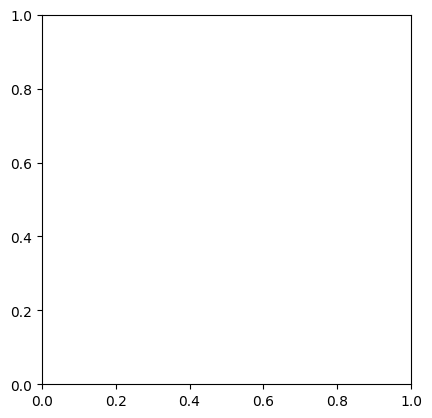

In [ ]:
for images, captions in train_loader:
    images = images.to(device)
    captions = captions.to(device)
    print(captions)
    for idxs in captions.tolist():
        sent = [vocabulary.itos[idx] for idx in idxs]
        print(sent)
        break
    plt.imshow(images[0].cpu())
    break
    predictions, alphas = model(images, captions)
    indexes = predictions.argmax(dim=-1)
    for idx in indexes.tolist():
        sent = [vocabulary.itos[idx] for idx in idx]
        print(sent)
    break

### What happens in validation

In [ ]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                         std=[0.26862954, 0.26130258, 0.27577711])
])
device = "cpu"
if torch.cuda.is_available():
    device = "cpu"
elif torch.backends.mps.is_available():
    device="mps"

print(f"Currently using the {device} device")
train_loader, dataset = get_loader(data_dict=train_data, transform=transform, vocabulary=vocabulary, image_folder="data/images/")
captioner = Caption(512, 512, 512, 512, len(vocabulary))
capitoner = model
captioner.to(device)
captioner.train()
for idx, (images, captions) in enumerate(train_loader):
    images= images.to(device)
    captions = captions.to(device)
    predictions, alpha = captioner(images, captions)
    words_idx = predictions.argmax(dim=-1)
    print(f"Shape of the cations batch: {captions.shape}")
    print(f"Shape of the prediction batch:{predictions.shape}")
    print(f"shape of word idx: {words_idx.shape}")
    print(f"shape of the alpha batch: {alpha.shape}")
    print(f"done with idx: {idx}")
    break


Currently using the mps device


/Users/ngkuissi/miniforge3/envs/ImageCap/lib/python3.8/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


Shape of the cations batch: torch.Size([32, 20])
Shape of the prediction batch:torch.Size([32, 20, 8508])
shape of word idx: torch.Size([32, 20])
shape of the alpha batch: torch.Size([32, 20, 196])
done with idx: 0


In [ ]:
image_path = 'data/images/10815824_2997e03d76.jpg'

# Load the image
image = Image.open(image_path)

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                         std=[0.26862954, 0.26130258, 0.27577711])
])

# Apply the transformation
image_tensor = transform(image)

# Add a batch dimension if needed
image_tensor = image_tensor.unsqueeze(0)
image_tensor = image_tensor.to(device)
model.caption_img(image_tensor, vocab=vocabulary)

RuntimeError: Placeholder storage has not been allocated on MPS device!

In [180]:
import torch
import torch.nn as nn

class BahdanauAttention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(BahdanauAttention, self).__init__()
        self.W_enc = nn.Linear(encoder_dim, attention_dim, bias=False)  # Transform encoder hidden states
        self.W_dec = nn.Linear(decoder_dim, attention_dim, bias=False)  # Transform decoder hidden state
        self.v = nn.Linear(attention_dim, 1, bias=False)  # Score function
        self.softmax = nn.Softmax(dim=1)  # Normalize attention scores

    def forward(self, encoder_outputs, decoder_hidden):
        """
        encoder_outputs: (batch_size, seq_len, encoder_dim)
        decoder_hidden: (batch_size, decoder_dim) - the last hidden state of the decoder
        
        Returns:
        - context vector: (batch_size, encoder_dim)
        - attention weights: (batch_size, seq_len)
        """
        # Expand decoder hidden state: (batch_size, 1, attention_dim)
        decoder_hidden_exp = self.W_dec(decoder_hidden).unsqueeze(1)
        
        # Compute attention scores: (batch_size, seq_len, attention_dim)
        scores = self.v(torch.tanh(self.W_enc(encoder_outputs) + decoder_hidden_exp))
        
        # Compute attention weights: (batch_size, seq_len, 1) → (batch_size, seq_len)
        attention_weights = self.softmax(scores.squeeze(2))
        
        # Compute context vector: (batch_size, encoder_dim)
        context_vector = torch.bmm(attention_weights.unsqueeze(1), encoder_outputs).squeeze(1)
        
        return context_vector, attention_weights


In [181]:
import torch

# Define input dimensions
batch_size = 64    # Number of sequences in a batch
seq_len = 50       # Sequence length (number of time steps)
encoder_dim = 512  # Encoder hidden dimension
decoder_dim = 1024 # Decoder hidden dimension
attention_dim = 256 # Attention layer size

# Initialize the BahdanauAttention model
attention = BahdanauAttention(encoder_dim, decoder_dim, attention_dim)

# Simulate large encoder outputs (batch_size, seq_len, encoder_dim)
encoder_outputs = torch.rand(batch_size, seq_len, encoder_dim)

# Simulate decoder hidden state (batch_size, decoder_dim)
decoder_hidden = torch.rand(batch_size, decoder_dim)

# Pass through the attention layer
context_vector, attn_weights = attention(encoder_outputs, decoder_hidden)

# Print tensor shapes
print("Context Vector Shape:", context_vector.shape)  # Expected: (64, 512)
print("Attention Weights Shape:", attn_weights.shape) # Expected: (64, 50)
print(attn_weights.max(dim=-1))


Context Vector Shape: torch.Size([64, 512])
Attention Weights Shape: torch.Size([64, 50])
torch.return_types.max(
values=tensor([0.0229, 0.0232, 0.0228, 0.0225, 0.0241, 0.0239, 0.0237, 0.0234, 0.0231,
        0.0251, 0.0229, 0.0230, 0.0242, 0.0221, 0.0232, 0.0249, 0.0242, 0.0230,
        0.0232, 0.0240, 0.0239, 0.0271, 0.0237, 0.0239, 0.0231, 0.0236, 0.0233,
        0.0231, 0.0238, 0.0234, 0.0226, 0.0239, 0.0241, 0.0260, 0.0243, 0.0235,
        0.0236, 0.0240, 0.0226, 0.0236, 0.0229, 0.0260, 0.0244, 0.0245, 0.0235,
        0.0253, 0.0240, 0.0231, 0.0242, 0.0233, 0.0232, 0.0230, 0.0227, 0.0243,
        0.0236, 0.0242, 0.0231, 0.0232, 0.0241, 0.0250, 0.0248, 0.0235, 0.0238,
        0.0248], grad_fn=<MaxBackward0>),
indices=tensor([18, 14, 28,  7,  9, 46, 14, 41, 11,  8, 33, 37, 33, 12, 14, 17, 33, 12,
         9, 27, 42, 22,  4, 20, 17,  1, 45, 47, 13, 22, 33,  9,  5, 41,  1, 47,
        32, 34,  7, 35, 31,  6, 44, 17,  4,  2, 36, 31, 18,  2, 44, 10,  4, 27,
        33, 43, 18, 23, 33, 2